In [15]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping











In [2]:
ticker = 'TSLA'
stock_data = yf.download(ticker, start="2015-01-01", end="2025-01-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
stock_data = stock_data[['Close']]

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_data)


In [6]:
train_size = int(len(scaled_data) *0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [7]:
def create_sequences(data, time_steps=60):
  X,y = [], []
  for i in range(len(data) - time_steps):
    X.append(data[i:i + time_steps])
    y.append(data[i + time_steps])
  return np.array(X), np.array(y)

time_steps = 60
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)


In [11]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(25, activation="relu"),
    Dense(1)

])

model.compile(optimizer="adam", loss="mae")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop],verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0350 - val_loss: 0.0496
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0092 - val_loss: 0.0555
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0079 - val_loss: 0.0368
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0067 - val_loss: 0.0332
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0063 - val_loss: 0.0691
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0070 - val_loss: 0.0422
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0075 - val_loss: 0.0354
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0066 - val_loss: 0.0435
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0064 - val_loss: 0.0317
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0061 - val_loss: 0.0294
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0055 - val_loss: 0.0309
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
predictions = model.predict(X_test)
predicitons = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [19]:
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

MAE: 230.28, MSE: 56382.31, RMSE: 237.45


In [25]:
last_60_days = scaled_data[-time_steps:]
future_predictions =[]

for _ in range(365):
  next_price = model.predict(last_60_days.reshape(1, time_steps, 1), verbose=0)
  future_predictions.append(next_price[0,0])
  last_60_days = np.append(last_60_days[1:], next_price).reshape(time_steps, 1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))


In [27]:
import datetime
start_date = stock_data.index[-1] + datetime.timedelta(days=1)
future_dates = [start_date + datetime.timedelta(days=i) for i in range(365)]

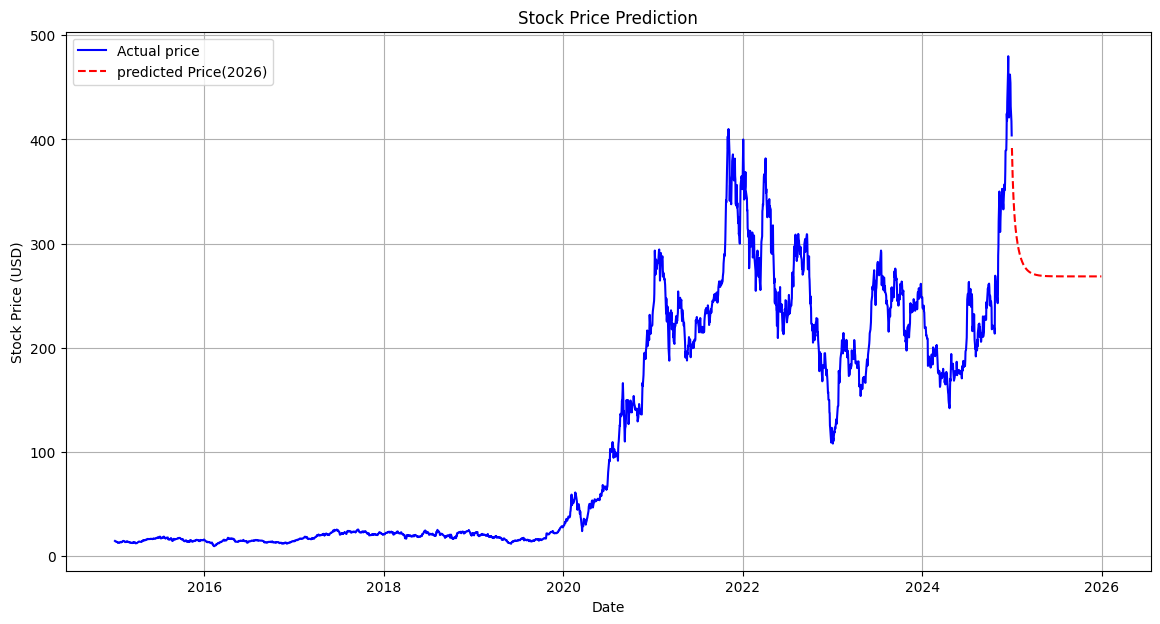

In [28]:
plt.figure(figsize=(14,7))
plt.plot(stock_data.index, stock_data['Close'], label="Actual price", color='blue')
plt.plot(future_dates, future_predictions, label="predicted Price(2026)", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Stock Price Prediction")
plt.legend()
plt.grid(True)
plt.show()